# Exercise 6.6: Time Series Analysis
## NYC Healthcare Access Equity Analysis

This notebook conducts a time series analysis on the **New York City unemployment rate** using data from the U.S. Bureau of Labor Statistics, retrieved via the Federal Reserve Economic Data (FRED) platform hosted by the Federal Reserve Bank of St. Louis. The data was downloaded directly as a CSV due to Quandl API access restrictions.

Source: U.S. Bureau of Labor Statistics, Unemployment Rate in New York City [NEWY636URN], retrieved from FRED (https://fred.stlouisfed.org/series/NEWY636URN)

NYC-specific unemployment data was chosen over the national rate because this project focuses entirely on NYC census tracts. Local unemployment more accurately reflects the economic conditions experienced by the communities identified in our clustering analysis, particularly during the COVID-19 spike when NYC unemployment exceeded the national average.

The analysis will decompose the time series into its components (trend, seasonality, noise), test for stationarity using the Dickey-Fuller test, and apply differencing techniques to prepare the data for forecasting.

In [1]:
# Import libraries
import quandl #ended up not using due to API restrictions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings

# Suppress warnings for cleaner output
warnings.filterwarnings("ignore")

# Set plot style
plt.style.use('fivethirtyeight')

In [2]:
# Load NYC unemployment rate data from FRED (downloaded as CSV)
# Source: U.S. Bureau of Labor Statistics, Unemployment Rate in New York City [NEWY636URN],
# retrieved from FRED (https://fred.stlouisfed.org/series/NEWY636URN)
data = pd.read_csv('/Users/jessduong/Documents/CF/Achievement 6/02 data/original data/NYC_UNRATE.csv',
                    parse_dates=['observation_date'])

In [3]:
# Rename columns for clarity
data.rename(columns={'observation_date': 'Date', 'NEWY636URN': 'Value'}, inplace=True)

In [4]:
# Set Date as the index
data.set_index('Date', inplace=True)

In [5]:
# Quick overview
print('Shape:', data.shape)
print(data.head())
print(data.tail())

Shape: (432, 1)
            Value
Date             
1990-01-01    5.4
1990-02-01    5.5
1990-03-01    5.2
1990-04-01    5.0
1990-05-01    5.1
            Value
Date             
2025-08-01    5.2
2025-09-01    5.3
2025-10-01    NaN
2025-11-01    4.7
2025-12-01    4.5


### Data Source
The NYC unemployment rate (NEWY636URN) was sourced from the U.S. Bureau of Labor Statistics, retrieved via the Federal Reserve Economic Data (FRED) website as a CSV download, due to Quandl API access restrictions. This monthly time series measures the civilian unemployment rate for New York City from January 1990 to December 2025 (432 observations).

Source: U.S. Bureau of Labor Statistics, Unemployment Rate in New York City [NEWY636URN], retrieved from FRED (https://fred.stlouisfed.org/series/NEWY636URN)

NYC-specific unemployment data was chosen over the national rate (UNRATE) because this project analyzes health disparities within NYC census tracts. Local unemployment more accurately reflects the economic conditions experienced by the communities in our analysis. Higher unemployment reduces household income, which our regression and clustering analyses showed is strongly associated with worse health outcomes.

In [6]:
# Subset to 2000-2024 to focus on modern economic conditions
# Earlier decades had different economic structures that could bias the analysis
# Exclude 2025 as recent data may be incomplete
data_sub = data.loc['2000-01-01':'2024-12-01'].copy()

In [7]:
# Drop any missing values
data_sub = data_sub.dropna()

In [8]:
# Verify the subset
print('Shape:', data_sub.shape)
print('Date range:', data_sub.index.min(), 'to', data_sub.index.max())
print('Missing values:', data_sub.isnull().sum().sum())

Shape: (300, 1)
Date range: 2000-01-01 00:00:00 to 2024-12-01 00:00:00
Missing values: 0


### Subsetting Logic
The original dataset spans 1990-2025 (432 observations). I subset to **January 2000 through December 2024** for the following reasons:
- Economic conditions in the early 1990s reflect a different NYC labor market that would bias the analysis
- This 25-year window captures multiple economic cycles (dot-com bust, 2008 financial crisis, COVID-19 shock, recovery)
- Data after December 2024 is excluded as recent months may have incomplete reporting
- 300 monthly observations provides sufficient data for decomposition and stationarity testing

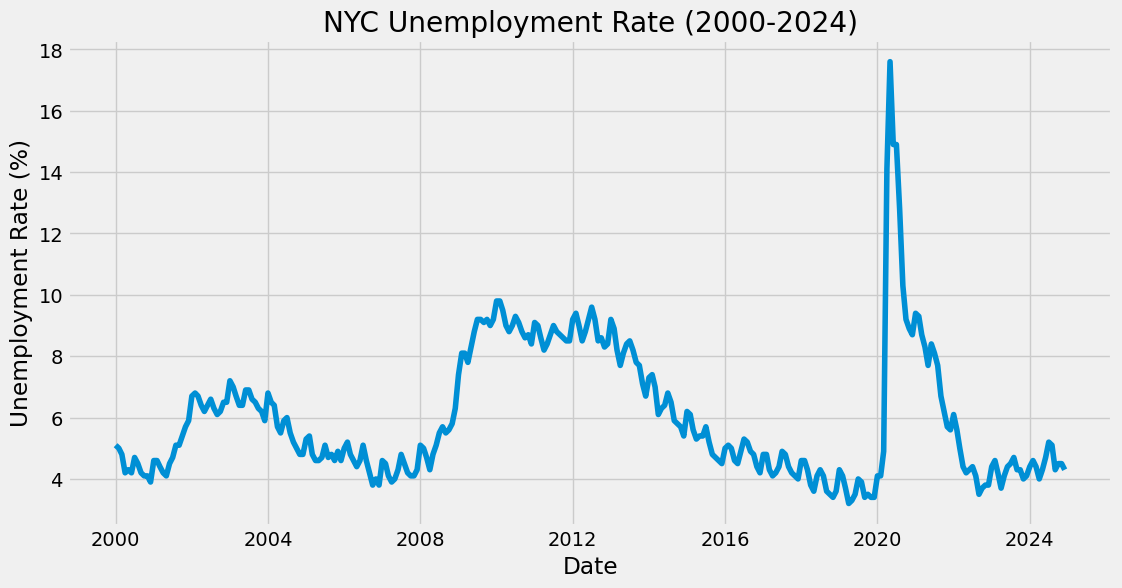

In [9]:
# Plot the NYC unemployment rate time series
plt.figure(figsize=(12, 6))
plt.plot(data_sub['Value'])
plt.xlabel('Date')
plt.ylabel('Unemployment Rate (%)')
plt.title('NYC Unemployment Rate (2000-2024)')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/NYC_unemployment_line_chart.png', dpi=150, bbox_inches='tight')
plt.show()

In [10]:
# Decompose the time series into trend, seasonality, and residual (noise)
# Using additive model since changes appear linear rather than exponential
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

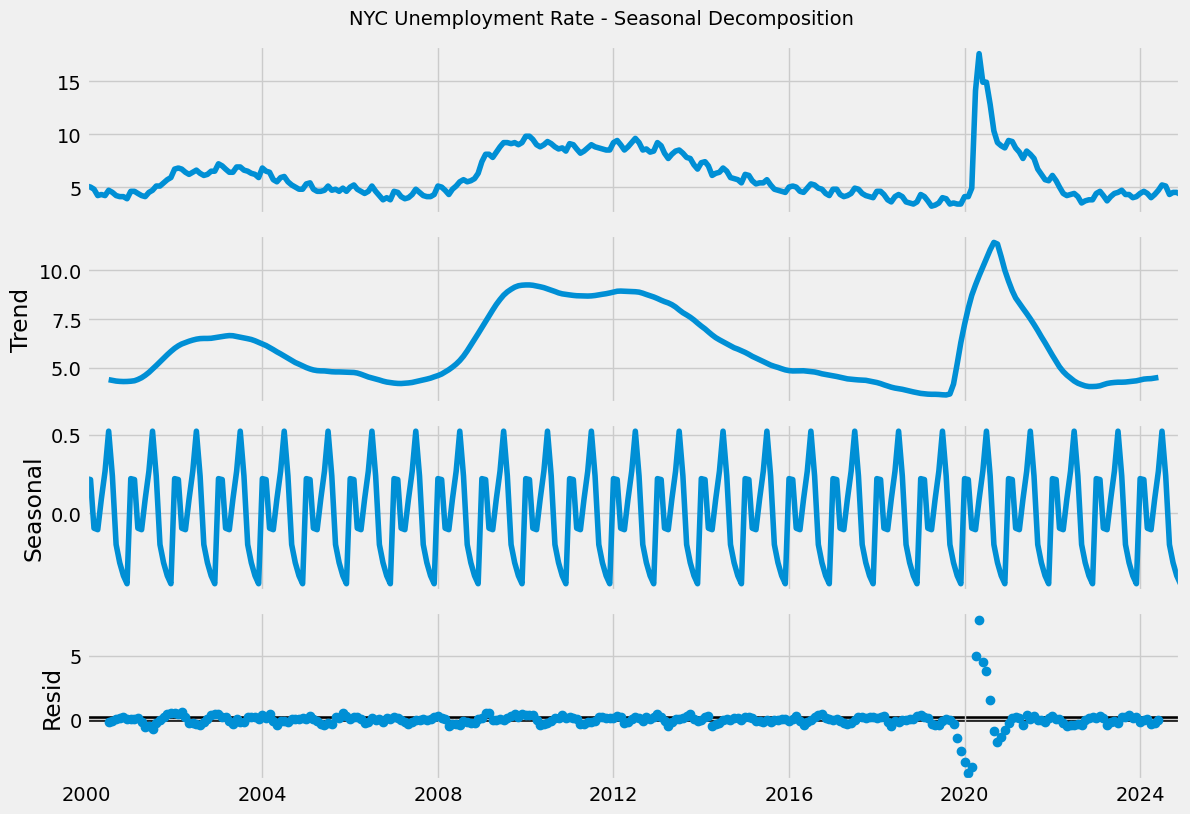

In [11]:
# Plot the decomposition
fig = decomposition.plot()
fig.set_size_inches(12, 8)
plt.tight_layout()
fig.suptitle('NYC Unemployment Rate - Seasonal Decomposition', fontsize=14, y=1.02)
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/decomposition_chart .png', dpi=150, bbox_inches='tight')
plt.show()

In [12]:
print(f"COVID peak: {data_sub.loc['2020'].max().values[0]}%")
print(f"Peak date: {data_sub.loc['2020'].idxmax().values[0]}")

COVID peak: 17.6%
Peak date: 2020-05-01T00:00:00.000000000


### Decomposition Analysis

The additive decomposition reveals four components of the NYC unemployment time series:

**Level (Original Data):** Shows the full NYC unemployment rate from 2000-2024, with two major spikes: the 2008 financial crisis (peaking near 10%) and the COVID-19 shock in 2020 (spiking to 17.6%, significantly higher than the national peak of ~15%).

**Trend:** The underlying long-term movement shows cyclical patterns driven by economic events. Unemployment trended upward from 2007-2010 during the Great Recession, then gradually declined through 2019. The COVID-19 spike appears as a sharp peak in 2020 followed by a slower recovery than the national average. By 2024, the trend has returned to pre-pandemic levels around 4-5%.

**Seasonality:** A clear repeating annual pattern is visible, with unemployment typically rising in winter months and falling in summer. The seasonal fluctuation is slightly larger than the national pattern (roughly +/- 0.5 percentage points), likely reflecting NYC's seasonal industries like tourism, hospitality, and construction.

**Residual (Noise):** Most of the residual noise is near zero, meaning the trend and seasonality explain the data well. The major exception is the COVID-19 period (2020), where several large residual spikes appear. This makes sense because the pandemic shock was an unprecedented event that neither the trend nor seasonal patterns could account for.

The presence of a clear trend confirms this data is likely **non-stationary**, which we will verify with the Dickey-Fuller test next.

In [13]:
# Import the Dickey-Fuller test
from statsmodels.tsa.stattools import adfuller

In [14]:
# Run the Dickey-Fuller test on the original subset
result = adfuller(data_sub['Value'])

In [15]:
# Display the results
print('Dickey-Fuller Test Results:')
print(f'Test Statistic: {result[0]:.4f}')
print(f'p-value: {result[1]:.4f}')
print(f'Lags Used: {result[2]}')
print(f'Number of Observations: {result[3]}')
print('Critical Values:')
for key, value in result[4].items():
    print(f'  {key}: {value:.4f}')

Dickey-Fuller Test Results:
Test Statistic: -2.7814
p-value: 0.0610
Lags Used: 4
Number of Observations: 295
Critical Values:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720


### Dickey-Fuller Test Results (Original Data)

**Null Hypothesis:** The time series has a unit root (is non-stationary).
**Alternative Hypothesis:** The time series has no unit root (is stationary).

- Test Statistic: -2.7814
- p-value: 0.0610
- Critical Value (1%): -3.4527
- Critical Value (5%): -2.8714
- Critical Value (10%): -2.5720

**Interpretation:** The test statistic (-2.7814) is larger than both the 1% and 5% critical values, and the p-value (0.061) exceeds 0.05. We cannot reject the null hypothesis: the NYC unemployment data is non-stationary. The clear trend visible in the decomposition confirms this. We need to apply differencing to remove the trend before the data could be used for forecasting.

In [16]:
# First round of differencing: subtract previous value from current value
data_diff = data_sub - data_sub.shift(1)

In [17]:
# Drop the NaN created by the shift
data_diff = data_diff.dropna()

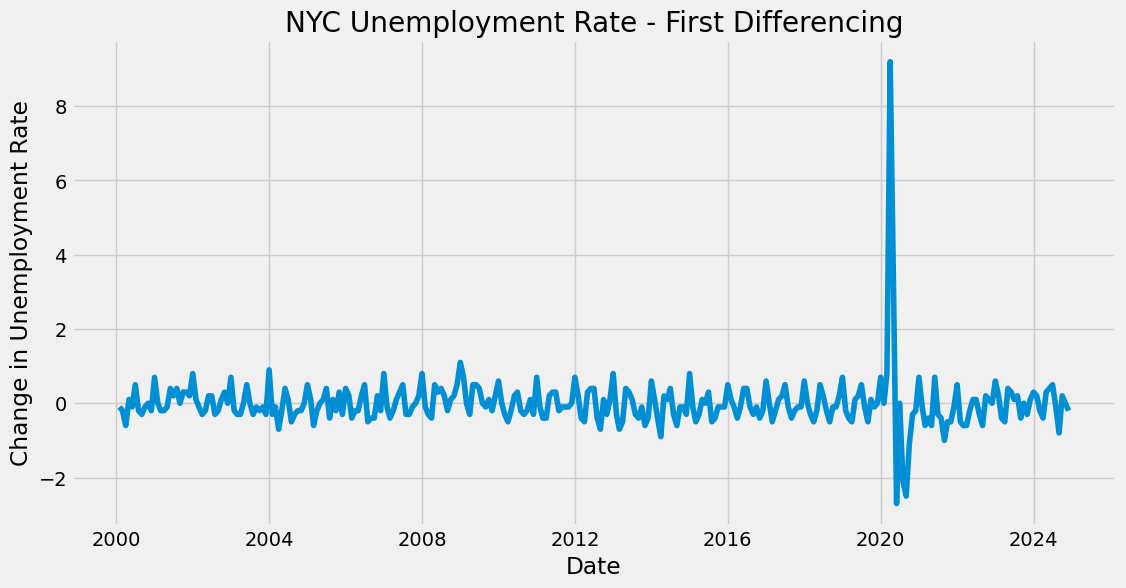

In [18]:
# Plot the differenced data
plt.figure(figsize=(12, 6))
plt.plot(data_diff['Value'])
plt.xlabel('Date')
plt.ylabel('Change in Unemployment Rate')
plt.title('NYC Unemployment Rate - First Differencing')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/first_differencing_plot.png', dpi=150, bbox_inches='tight')
plt.show()

In [19]:
# Run Dickey-Fuller test on the differenced data
result_diff = adfuller(data_diff['Value'])

In [20]:
# Display the results
print('Dickey-Fuller Test Results (After First Differencing):')
print(f'Test Statistic: {result_diff[0]:.4f}')
print(f'p-value: {result_diff[1]:.6f}')
print(f'Lags Used: {result_diff[2]}')
print(f'Number of Observations: {result_diff[3]}')
print('Critical Values:')
for key, value in result_diff[4].items():
    print(f'  {key}: {value:.4f}')

Dickey-Fuller Test Results (After First Differencing):
Test Statistic: -10.6300
p-value: 0.000000
Lags Used: 3
Number of Observations: 295
Critical Values:
  1%: -3.4527
  5%: -2.8714
  10%: -2.5720


### Dickey-Fuller Test Results (After First Differencing)

**Null Hypothesis:** The time series has a unit root (is non-stationary).

- Test Statistic: -10.6300
- p-value: 0.000000
- Critical Value (1%): -3.4527
- Critical Value (5%): -2.8714
- Critical Value (10%): -2.5720

**Interpretation:** The test statistic (-10.6300) is far smaller than all critical values, including the 1% level (-3.4527). The p-value is essentially zero. We can confidently reject the null hypothesis: the differenced NYC unemployment data is stationary. No second round of differencing is needed.

In [21]:
# Plot autocorrelation of the differenced data
from statsmodels.graphics.tsaplots import plot_acf

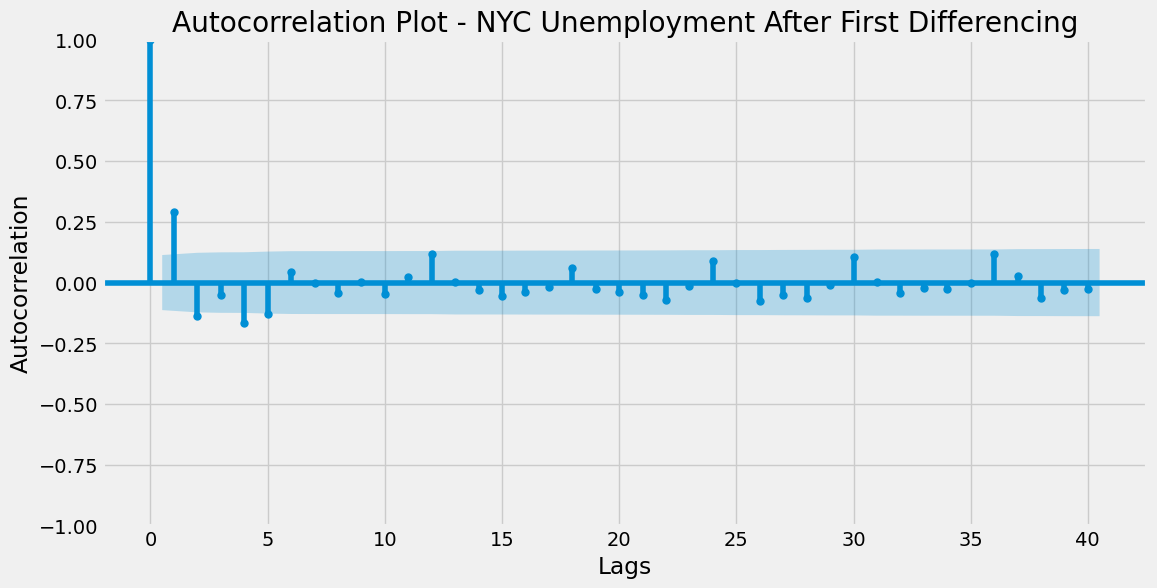

In [22]:
fig, ax = plt.subplots(figsize=(12, 6))
plot_acf(data_diff['Value'], lags=40, ax=ax)
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Plot - NYC Unemployment After First Differencing')
plt.savefig('/Users/jessduong/Documents/CF/Achievement 6/04 analysis/visualizations/autocorrelation_plot.png', dpi=150, bbox_inches='tight')
plt.show()

### Autocorrelation Check

The autocorrelation plot shows that after first differencing, nearly all lags fall within the blue confidence interval. Only lag 1 shows moderate significance (~0.3), which is expected. If unemployment jumped this month, next month's change is somewhat related. Beyond that, no meaningful autocorrelation remains.

Since fewer than 10 lags exceed the confidence interval, no second round of differencing is needed. The first differencing successfully removed both the trend and autocorrelation from the NYC unemployment data, making it suitable for forecasting models (such as ARIMA).

### Connection to NYC Healthcare Equity Analysis

NYC unemployment data adds a critical temporal dimension to our cross-sectional health analysis:

- **2008 Financial Crisis:** NYC unemployment rose from ~4.5% to nearly 10%, likely worsening health outcomes in low-income communities like those in Cluster 3 (Bronx) where income is the primary driver of health disparities
- **COVID-19 Shock (2020):** NYC unemployment spiked to 17.6%, coinciding directly with our health data period (2018-2022). The communities with the worst health outcomes (Cluster 3) were likely hit hardest by this economic shock

- **Seasonal Patterns:** NYC unemployment rises in winter and falls in summer, mirroring seasonal healthcare utilization and chronic disease management challenges

The time series confirms that the economic forces driving health disparities are cyclical and predictable, with vulnerable communities bearing the greatest burden during economic downturns. This supports targeted, proactive resource allocation rather than reactive crisis response.

In [22]:
# Export the subset NYC unemployment data for Tableau
data_sub.to_csv('/Users/jessduong/Documents/CF/Achievement 6/02 data/Prepared Data/nyc_unemployment_2000_2024.csv')
print('Exported:', data_sub.shape)

Exported: (300, 1)
